**Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

**Data loading & Preprocessing**

In [ ]:
# Load the dataset
import pandas as pd

df = pd.read_csv('/content/Churn_Modelling.csv')

# View column info
print(df.info())

# Drop irrelevant columns that don't help in prediction
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Display the first few rows to confirm preprocessing
print("\nSample of processed data:")
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None

Missing values per column:
CreditScore        0
Geography          0
Gender             

**Exploratory Data Analysis (EDA):**

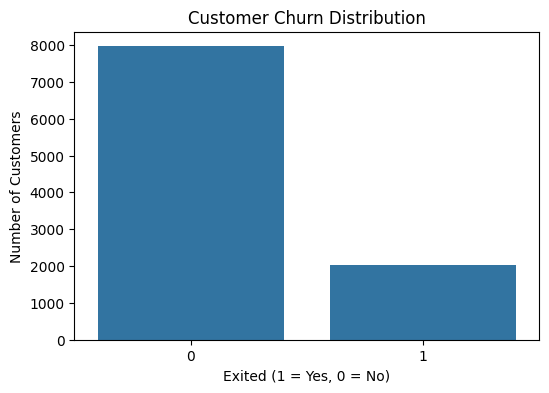

In [ ]:
import matplotlib.pyplot as plt

# Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Exited')
plt.title("Customer Churn Distribution")
plt.xlabel("Exited (1 = Yes, 0 = No)")
plt.ylabel("Number of Customers")
plt.show()




<ipython-input-47-786865ad618d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=churn_geo.index, y=churn_geo.values, palette='Blues')


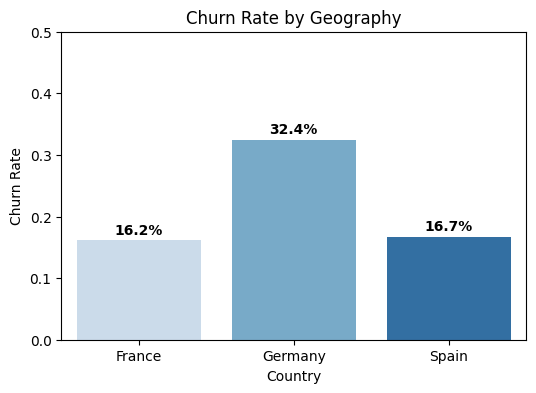

In [ ]:
# Create back the 'Geography' label from dummy columns
df['Geography_Label'] = np.where(df['Geography_Germany'] == 1, 'Germany',
                          np.where(df['Geography_Spain'] == 1, 'Spain', 'France'))

# Now group by new Geography_Label
churn_geo = df.groupby('Geography_Label')['Exited'].mean()

plt.figure(figsize=(6,4))
ax = sns.barplot(x=churn_geo.index, y=churn_geo.values, palette='Blues')
plt.title('Churn Rate by Geography')
plt.ylabel('Churn Rate')
plt.xlabel('Country')
plt.ylim(0, 0.5)

# Add % labels
for i, v in enumerate(churn_geo.values):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha='center', fontweight='bold')

plt.show()


<ipython-input-48-2dd2d8b63d12>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_products.index, y=churn_products.values, palette='Greens')


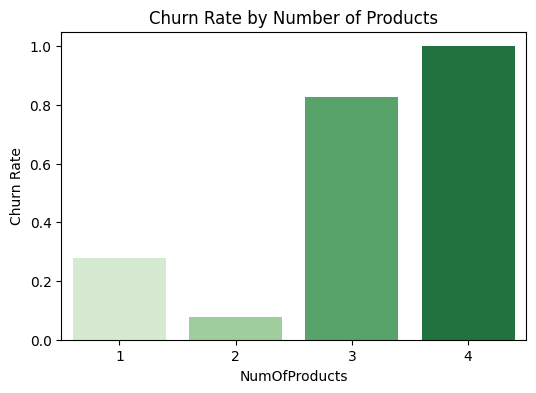

In [ ]:
plt.figure(figsize=(6,4))
churn_products = df.groupby('NumOfProducts')['Exited'].mean()
sns.barplot(x=churn_products.index, y=churn_products.values, palette='Greens')
plt.title('Churn Rate by Number of Products')
plt.ylabel('Churn Rate')
plt.show()


<ipython-input-49-38a3e0a31ab6>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  churn_age = df.groupby('AgeGroup')['Exited'].mean()
<ipython-input-49-38a3e0a31ab6>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_age.index, y=churn_age.values, palette='Oranges')


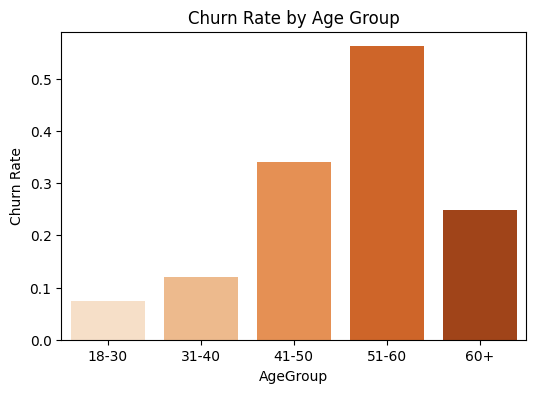

In [ ]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '31-40', '41-50', '51-60', '60+'])

plt.figure(figsize=(6,4))
churn_age = df.groupby('AgeGroup')['Exited'].mean()
sns.barplot(x=churn_age.index, y=churn_age.values, palette='Oranges')
plt.title('Churn Rate by Age Group')
plt.ylabel('Churn Rate')
plt.show()


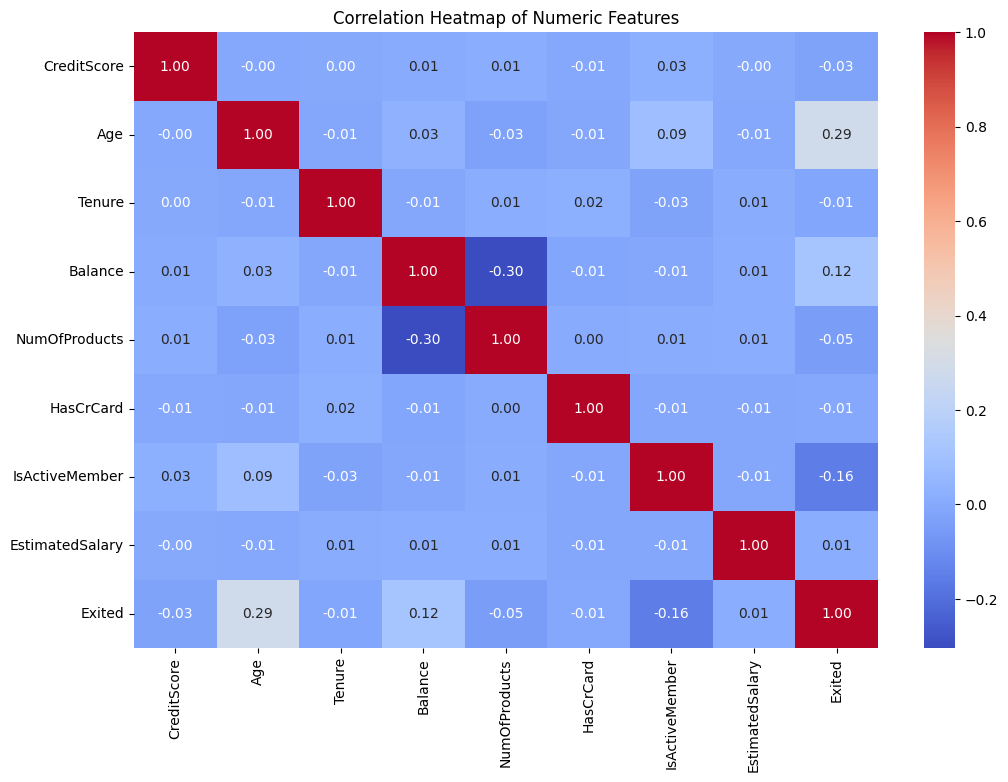

In [ ]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

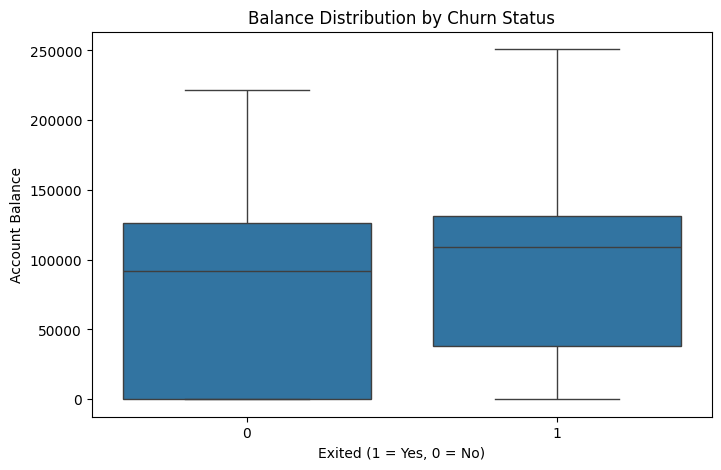

In [ ]:
# Boxplot Example: Balance vs. Churn
plt.figure(figsize=(8, 5))
sns.boxplot(x='Exited', y='Balance', data=df)
plt.title("Balance Distribution by Churn Status")
plt.xlabel("Exited (1 = Yes, 0 = No)")
plt.ylabel("Account Balance")
plt.show()

**Feature Engineering and Data Scaling:**

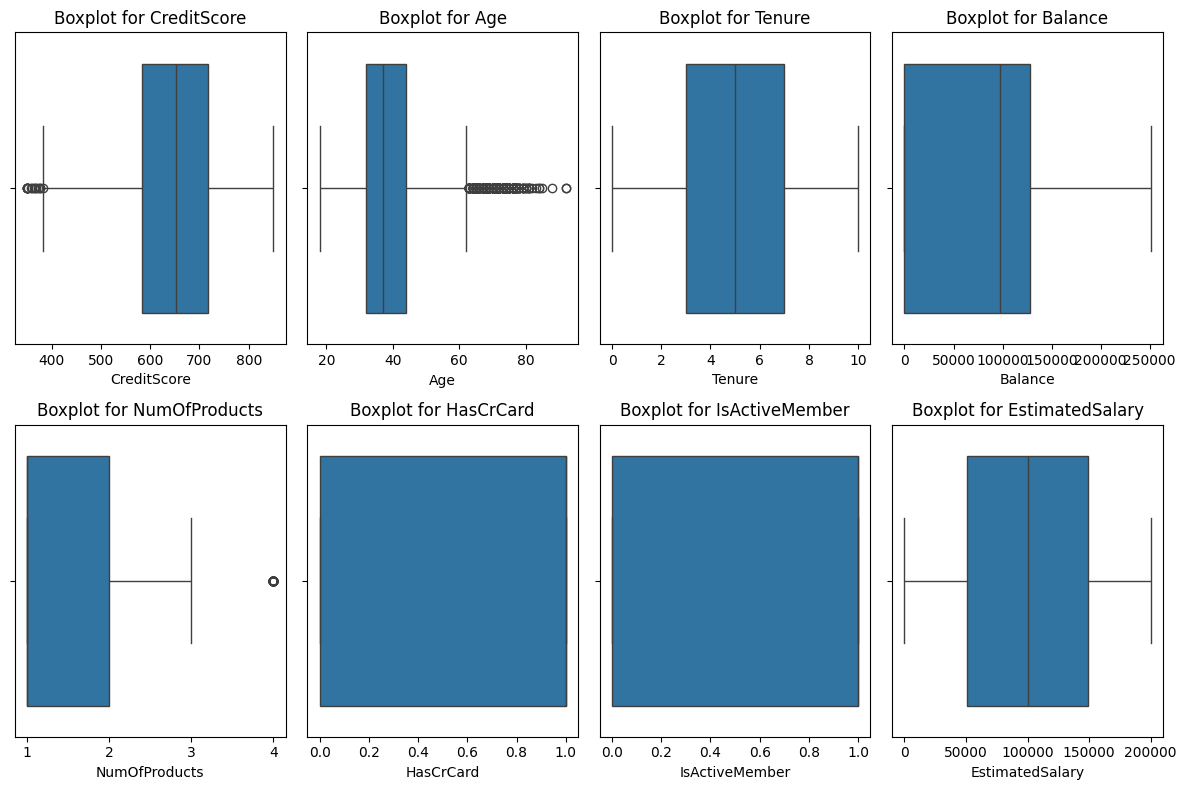

In [ ]:
# Select only numeric columns (excluding target if you want)
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()

# If you want to exclude target column (Exited) from boxplots:
numerical_features = [col for col in numerical_features if col != 'Exited']

# Create boxplots to visually identify outliers for each numerical feature
plt.figure(figsize=(12, 8))

# Calculate the number of rows and columns for subplots
num_features = len(numerical_features)
cols = 4
rows = (num_features // cols) + (num_features % cols > 0)  # Add extra row if needed

for i, feature in enumerate(numerical_features):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot for {feature}")

plt.tight_layout()
plt.show()

**Model Training and Evaluation:**

In [ ]:
# Load and clean data
df = pd.read_csv('Churn_Modelling.csv')
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

# Create AgeGroup column
df['AgeGroup'] = pd.cut(df['Age'],
                        bins=[18, 30, 40, 50, 60, 100],
                        labels=['18-30', '31-40', '41-50', '51-60', '60+'])

# Create BalanceRange column
df['BalanceRange'] = pd.cut(df['Balance'],
                            bins=[-1, 0, 50000, 100000, 200000, np.inf],
                            labels=['Zero', 'Low', 'Medium', 'High', 'Very High'])

# One-hot encode ALL categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

# Set features and target
X = df_encoded.drop('Exited', axis=1)
y = df_encoded['Exited']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a pandas DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a table
print("\nClassification Report (Table format):")
print(report_df)



Classification Report (Table format):
              precision    recall  f1-score   support
0              0.880318  0.965775  0.921068  1607.000
1              0.767932  0.463104  0.577778   393.000
accuracy       0.867000  0.867000  0.867000     0.867
macro avg      0.824125  0.714440  0.749423  2000.000
weighted avg   0.858234  0.867000  0.853612  2000.000


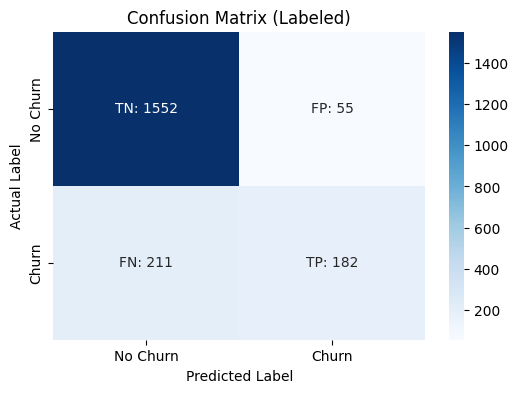

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Map matrix elements
TN, FP, FN, TP = conf_matrix.ravel()

# Create a labeled confusion matrix
labels = np.array([[f'TN: {TN}', f'FP: {FP}'],
                   [f'FN: {FN}', f'TP: {TP}']])

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues',
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])

plt.title("Confusion Matrix (Labeled)")
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.77      0.46      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.75      2000
weighted avg       0.86      0.87      0.85      2000

Random Forest Accuracy: 0.867


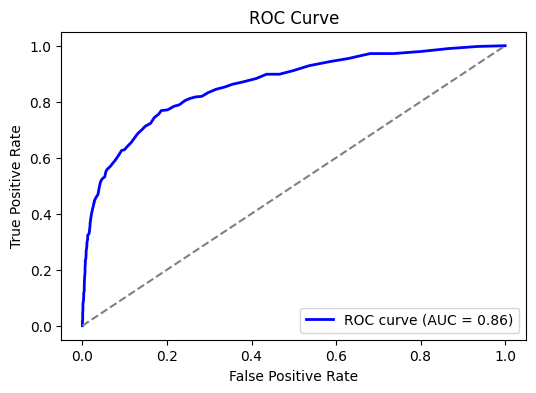

In [ ]:
# ROC Curve (Receiver Operating Characteristic Curve)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

**K-Nearest Neighbors (KNN) Model:**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train a KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)

# Evaluate the model
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1607
           1       0.59      0.41      0.48       393

    accuracy                           0.83      2000
   macro avg       0.73      0.67      0.69      2000
weighted avg       0.81      0.83      0.81      2000

KNN Accuracy: 0.8275


**Hyperparameter Tuning with RandomizedSearchCV (for Random Forest):**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10, cv=5, n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters and model
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_:.4f}")

Best Hyperparameters: {'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 70}
Best Score: 0.8619


**Precision-Recall Analysis:**

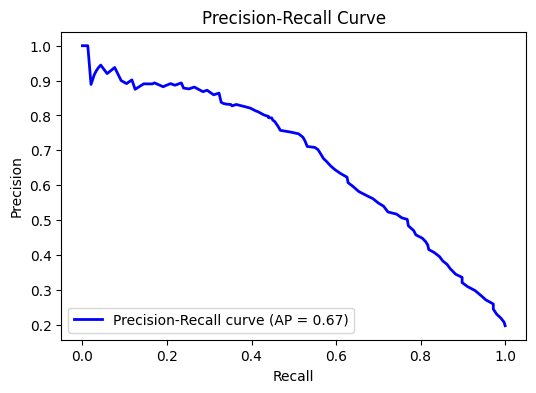

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class (churn)
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Calculate Average Precision (AP) score
ap_score = average_precision_score(y_test, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {ap_score:.2f})')
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

**Cross-Validation:**

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation (can adjust the number of folds)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")


Cross-validation scores: [0.855  0.8665 0.8595 0.867  0.8595]
Mean cross-validation score: 0.8615


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'random_state': [42]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit the randomized search
random_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Cross-validation Score: {random_search.best_score_:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters: {'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 70, 'random_state': 42}
Best Cross-validation Score: 0.8620


**Feature Importance:**

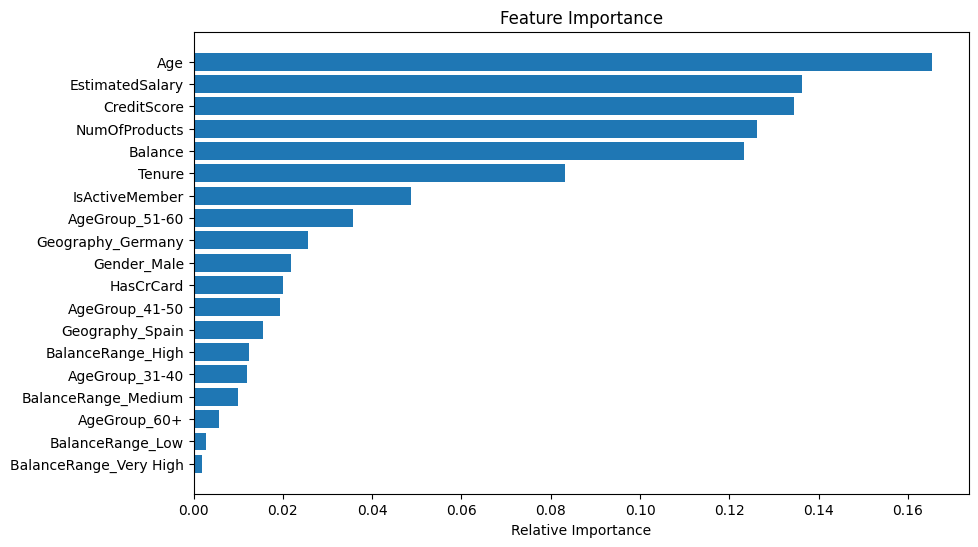

In [ ]:
feature_names = X.columns  # Store feature names before scaling

# Plot feature importance
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), feature_names[indices])  # Use the feature names stored earlier
plt.xlabel("Relative Importance")
plt.show()